# Potentially unexpressed genes
It is assumed that if genes are unexpressed or have too high noise the reads will be mapped relatively differently (different profile) between the replicates than if the replicates differ only slightly in developmental timecourse (e. g. inconsistent patterns between replicates probably indcates random read mapping). Here are calculated similarities of gene profile between the two replicates for each gene in each strain. 

In [1]:
import os
import sys
from importlib import reload

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0,module_path)

import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
import numpy as np

import library_regulons
reload(library_regulons)
from library_regulons import *
import jupyter_functions as jf
reload(jf)
import jupyter_functions as jf
from functionsDENet import loadPickle, savePickle
from correlation_enrichment.library_correlation_enrichment import SimilarityCalculator


In [2]:
dataPath = '/home/karin/Documents/timeTrajectories/data/RPKUM/combined/'
pathSave='/home/karin/Documents/timeTrajectories/data/regulons/selected_genes/thresholds/'

In [3]:
genes = pd.read_csv(dataPath + 'mergedGenes_RPKUM.tsv', sep='\t', index_col=0)
conditions = pd.read_csv(dataPath + 'conditions_mergedGenes.tsv', sep='\t', index_col=None)
genes_zero_count=pd.read_table(dataPath + 'zero_replicates_count.tsv', index_col=0)

In [23]:
# Sorts conditions  by replicate and strain so that later measuremnts can be retrieved ordered in time 
# and AX4 replicates with same N points (FD, SE, PE) are listed together
conditions=conditions.sort_values(['Replicate','Time'])

In [25]:
# Split by replicate (and sort by time)
SPLITBY = 'Replicate'
merged = ClusterAnalyser.merge_genes_conditions(genes=genes, conditions=conditions[['Measurment', SPLITBY]],
                                                matching='Measurment')
splitted = ClusterAnalyser.split_data(data=merged, split_by=SPLITBY)
for rep, data in splitted.items():
    data = data.drop([SPLITBY, 'Measurment'], axis=1).T
    #Sort by time
    splitted[rep]=data.loc[:,conditions[conditions[SPLITBY]==rep]['Measurment']]


In [48]:
# Calculate similarities between gene profiles of replicates from the same strain, 
# exclude genes that zero in any replicate
LOG=True
SCALE='mean0std1'

strains=conditions['Strain'].unique()
similarities_df=np.empty((genes.shape[0],strains.shape[0]))
similarities_df[:]=np.nan
strains_idxs=dict(zip(strains,range(strains.shape[0])))
genes_idxs=dict(zip(genes.index,range(genes.index.shape[0])))

for strain in strains:
    reps=conditions[conditions['Strain']==strain]['Replicate'].unique()[:2]
    genes_not_zero=genes_zero_count[genes_zero_count[strain]==0].index
    print(reps,len(genes_not_zero))
    
    # Normalise replicate data of not zero genes
    data1=pd.DataFrame(
        NeighbourCalculator.get_index_query(genes=splitted[reps[0]].loc[genes_not_zero,:], 
                                            inverse=False, scale=SCALE, log=LOG)[0],
        index=genes_not_zero,columns=splitted[reps[0]].columns)
    data2=pd.DataFrame(
        NeighbourCalculator.get_index_query(genes=splitted[reps[1]].loc[genes_not_zero,:], 
                                            inverse=False, scale=SCALE, log=LOG)[0],
        index=genes_not_zero,columns=splitted[reps[1]].columns)
    # Remove pairs that contain gene which is constantly 0 in that strain
    for gene in genes_not_zero:
        sim=SimilarityCalculator.calc_cosine(data1.loc[gene,:],data2.loc[gene,:])
        similarities_df[genes_idxs[gene],strains_idxs[strain]]=sim
        
similarities_df=pd.DataFrame(similarities_df,index=genes.index, columns=strains)

['AX4_FD_r1' 'AX4_FD_r2'] 11501
['MybBGFP_r1' 'MybBGFP_r2'] 12029
['PkaCoe_r2' 'PkaCoe_r3'] 11903
['ac3PkaCoe_r1' 'ac3PkaCoe_r2'] 11775
['acaAPkaCoe_r1' 'acaAPkaCoe_r2'] 12019
['acaA_r1' 'acaA_r2'] 11584
['amiB_r1' 'amiB_r2'] 11182
['comH_r1' 'comH_r2'] 12175
['cudA_r2' 'cudA_r3'] 11424
['dgcA_r1' 'dgcA_r2'] 11595
['ecmARm_r1' 'ecmARm_r2'] 12171
['gbfA_r1' 'gbfA_r2'] 11417
['gtaC_r1' 'gtaC_r2'] 10706
['gtaG_r1' 'gtaG_r2'] 11716
['gtaI_r1' 'gtaI_r2'] 11740
['mybB_r1' 'mybB_r2'] 11514
['pkaR_r1' 'pkaR_r2'] 12090
['tagB_r1' 'tagB_r2'] 11881
['tgrB1C1_r1' 'tgrB1C1_r2'] 11817
['tgrB1_r1' 'tgrB1_r2'] 11495
['tgrC1_r1' 'tgrC1_r2'] 11622


Distribution of similarities between gene profiles in two replicates for each strain.  X: Cosine similarity, Y: Count of genes that had such similarity between the two replicates.

/home/karin/Documents/git/orange3venv/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/karin/Documents/git/orange3venv/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


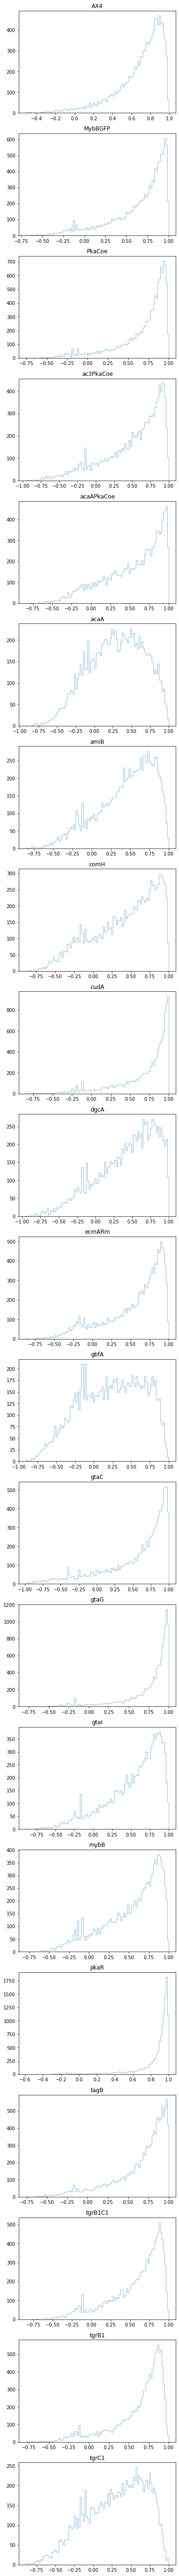

In [70]:
fig, axs = plt.subplots(len(strains), 1,figsize=(6,100))
axN=-1
for strain in strains:
    axN+=1
    sims=similarities_df[strain]
    axs[axN].hist(sims, bins=100, histtype = 'step', fill = None, alpha=0.5)
    axs[axN].set_title(strain) 

Based on the plots of gene profile similarities between the replicates it does not seem to be possible to select a threshold based on which it could be determined if gene is expressed or not.